# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)
#glob模块的主要方法就是glob,该方法返回所有匹配的文件路径列表（list）；
#该方法需要一个参数用来指定匹配的路径字符串（字符串可以为绝对路径也可以为相对路径），
#其返回的文件名只包括当前目录里的文件名，不包括子文件夹里的文件。
# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/lfw/*/*"))#对这里根据实际目录进行了修改。获取目录下的所有文件，即对应所有图片
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1
(250, 250, 3)


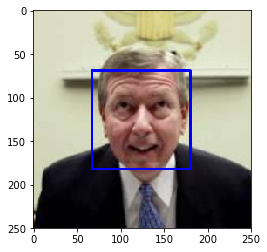

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[-1])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(cv_rgb.shape)
# display the image, along with bounding box
plt.imshow(cv_rgb)
#plt.imshow(img)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [9]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_shor:t and dog_files_short.
h_counter=0.
d_counter=0.
dog_with_face=[]#将把狗狗误认为人脸的图片保存
for h_image in human_files_short:
    if face_detector(h_image):
        h_counter+=1.     
for d_image in dog_files_short:
    if face_detector(d_image):
        d_counter+=1.
        dog_with_face.append(d_image)#将把狗狗误认为人脸的图片保存
print('the percentage of human face in the first 100 images of human_files is '+str(h_counter)+'%')
print('the percentage of human face in the first 100 images of dog_files is '+str(d_counter)+'%')

the percentage of human face in the first 100 images of human_files is 99.0%
the percentage of human face in the first 100 images of dog_files is 12.0%


12


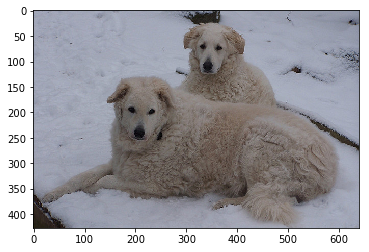

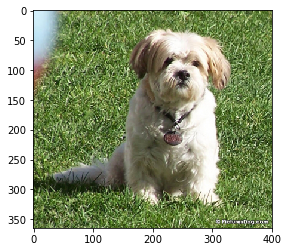

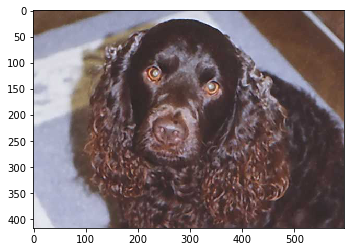

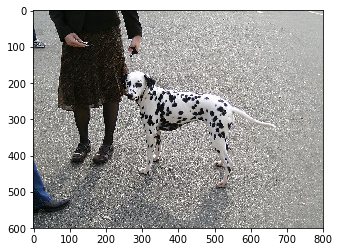

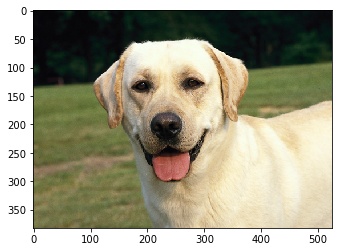

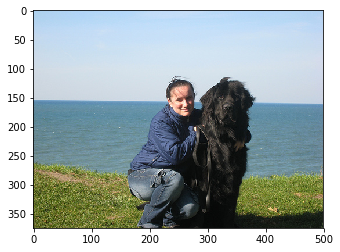

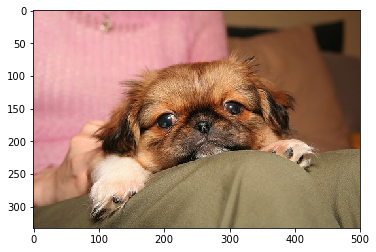

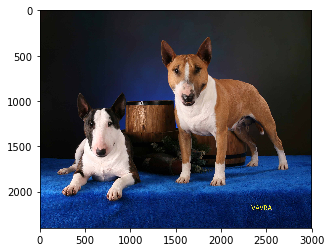

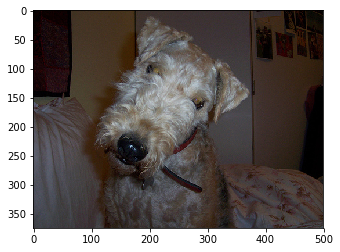

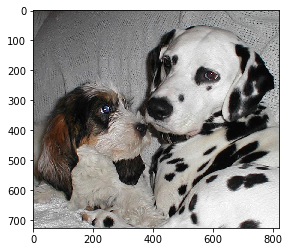

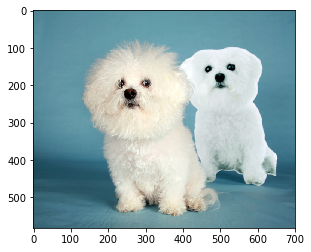

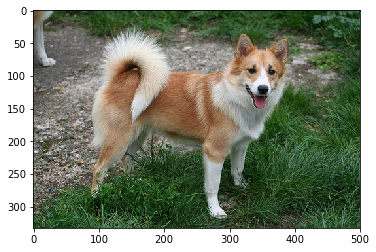

In [10]:
#将把狗狗误认为人脸的图片显示出来，以便观察异常

print(len(dog_with_face))
for i in range(len(dog_with_face)):
    plt.figure(i)        
    # load color (BGR) image
    img = cv2.imread(dog_with_face[i])
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    #plt.imshow(img)
    plt.show()
    


可见此人脸检测算法，会将一些狗的面孔误认为是人，特别是图片中包含两只狗狗的情况，还需要改进。


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.


此人脸检测算法，采用opencv预先训练好的模型，直接调用，使用很方便。通过以上的检测结果来看，对人脸的检测准确率还是很高的，但是，其会将一些狗狗的面孔误认为是人脸，这一点还需要改进，以减少误报。
由于本项目所用的人脸数据集人脸较为清晰，那么该Haar级联人脸检测算法可适用于本项目。
此外，暂时还没有找的其他简单易用且准确率更高的人脸检测算法。


In [ ]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [5]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [7]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_shor:t and dog_files_short.
h_counter=0.
d_counter=0.
for h_image in human_files_short:
    if dog_detector(h_image):
        h_counter+=1.     
for d_image in dog_files_short:
    if dog_detector(d_image):
        d_counter+=1.
        
print('the percentage of dog in the first 100 images of human_files is '+str(h_counter)+'%')
print('the percentage of dog in the first 100 images of dog_files is '+str(d_counter)+'%')



the percentage of dog in the first 100 images of human_files is 1.0%
the percentage of dog in the first 100 images of dog_files is 100.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
# valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
# test_tensors = paths_to_tensor(test_files).astype('float32')/255


100%|█████████████████████████████████████████████████████████| 6680/6680 [00:55<00:00, 120.61it/s]


In [12]:
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████| 836/836 [00:17<00:00, 47.01it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [13]:
print(train_tensors.shape)
print(valid_tensors.shape)
print(test_tensors.shape)

(6680, 224, 224, 3)
(835, 224, 224, 3)
(836, 224, 224, 3)


In [9]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
#结合自身电脑的运算情况，采用四层卷积层，一层全连接层的结构
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
#model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       32896     
__________


结合自身电脑的配置情况（配置较低），以及问题要求大于1%的正确率，在给定的模型结构提示基础上，采用了四层卷积层，一层全连接层的结构，卷积层提取高级特征向量，全连接层做输出分类，由于只有一层全连接层，所以就没有引入Dropout策略，但训练时采用了数据集增强的方法来提高泛化能力。


### Compile the Model

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [16]:

# # This will do preprocessing and realtime data augmentation:
# datagen = ImageDataGenerator(
#     featurewise_center=False,  # set input mean to 0 over the dataset
#     samplewise_center=False,  # set each sample mean to 0
#     featurewise_std_normalization=False,  # divide inputs by std of the dataset
#     samplewise_std_normalization=False,  # divide each input by its std
#     zca_whitening=False,  # apply ZCA whitening
#     rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=False)  # randomly flip images

# # Compute quantities required for feature-wise normalization
# # (std, mean, and principal components if ZCA whitening is applied).
# datagen.fit(x_train)



#训练时采用了增强数据集的方法来提高泛化能力
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (20%of total width)
    height_shift_range=0.2,  # randomly shift images vertically (20% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (20% of total width)
    height_shift_range=0.2,  # randomly shift images vertically (20% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
# datagen_train.fit(train_tensors)
# datagen_valid.fit(valid_tensors)



In [20]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5
batch_size=20
### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

# model.fit(train_tensors, train_targets, 
#           validation_data=(valid_tensors, valid_targets),
#           epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

#训练时采用了增强数据集的方法来提高泛化能力
model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)


Epoch 1/5
334/334 [==============================] - 274s 820ms/step - loss: 4.7276 - acc: 0.0232 - val_loss: 4.7569 - val_acc: 0.0232
Epoch 2/5


204/334 [=================>............] - ETA: 4:08 - loss: 4.5777 - acc: 0.050 - ETA: 4:12 - loss: 4.6804 - acc: 0.025 - ETA: 4:14 - loss: 4.6190 - acc: 0.016 - ETA: 4:15 - loss: 4.6790 - acc: 0.012 - ETA: 4:14 - loss: 4.6824 - acc: 0.010 - ETA: 4:14 - loss: 4.6789 - acc: 0.016 - ETA: 4:13 - loss: 4.6847 - acc: 0.014 - ETA: 4:12 - loss: 4.6708 - acc: 0.031 - ETA: 4:12 - loss: 4.6842 - acc: 0.027 - ETA: 4:13 - loss: 4.6722 - acc: 0.025 - ETA: 4:13 - loss: 4.6709 - acc: 0.027 - ETA: 4:16 - loss: 4.6720 - acc: 0.025 - ETA: 4:17 - loss: 4.6703 - acc: 0.023 - ETA: 4:16 - loss: 4.6847 - acc: 0.021 - ETA: 4:15 - loss: 4.6853 - acc: 0.023 - ETA: 4:14 - loss: 4.6834 - acc: 0.021 - ETA: 4:14 - loss: 4.6743 - acc: 0.020 - ETA: 4:13 - loss: 4.6938 - acc: 0.022 - ETA: 4:12 - loss: 4.6931 - acc: 0.021 - ETA: 4:11 - loss: 4.6924 - acc: 0.020 - ETA: 4:10 - loss: 4.6927 - acc: 0.021 - ETA: 4:11 - loss: 4.6903 - acc: 0.025 - ETA: 4:10 - loss: 4.6936 - acc: 0.023 - ETA: 4:09 - loss: 4.6866 - acc: 0.025

334/334 [==============================] - 278s 833ms/step - loss: 4.6983 - acc: 0.0257 - val_loss: 4.7329 - val_acc: 0.0268
Epoch 3/5
334/334 [==============================] - 285s 852ms/step - loss: 4.6575 - acc: 0.0332 - val_loss: 4.6608 - val_acc: 0.0390
Epoch 4/5


204/334 [=================>............] - ETA: 4:29 - loss: 4.7008 - acc: 0.0000e+0 - ETA: 4:23 - loss: 4.6239 - acc: 0.0250    - ETA: 4:22 - loss: 4.6303 - acc: 0.033 - ETA: 4:19 - loss: 4.5773 - acc: 0.050 - ETA: 4:18 - loss: 4.5897 - acc: 0.040 - ETA: 4:18 - loss: 4.5900 - acc: 0.033 - ETA: 4:17 - loss: 4.5736 - acc: 0.035 - ETA: 4:15 - loss: 4.5769 - acc: 0.037 - ETA: 4:15 - loss: 4.5542 - acc: 0.033 - ETA: 4:14 - loss: 4.5595 - acc: 0.030 - ETA: 4:15 - loss: 4.5601 - acc: 0.031 - ETA: 4:14 - loss: 4.5542 - acc: 0.029 - ETA: 4:14 - loss: 4.5624 - acc: 0.026 - ETA: 4:13 - loss: 4.5462 - acc: 0.028 - ETA: 4:12 - loss: 4.5457 - acc: 0.030 - ETA: 4:12 - loss: 4.5549 - acc: 0.034 - ETA: 4:11 - loss: 4.5644 - acc: 0.032 - ETA: 4:10 - loss: 4.5642 - acc: 0.030 - ETA: 4:09 - loss: 4.5604 - acc: 0.031 - ETA: 4:08 - loss: 4.5772 - acc: 0.030 - ETA: 4:08 - loss: 4.5636 - acc: 0.031 - ETA: 4:06 - loss: 4.5698 - acc: 0.029 - ETA: 4:06 - loss: 4.5748 - acc: 0.030 - ETA: 4:05 - loss: 4.5728 - ac

334/334 [==============================] - 275s 823ms/step - loss: 4.6028 - acc: 0.0413 - val_loss: 4.6389 - val_acc: 0.0329
Epoch 5/5
334/334 [==============================] - 280s 839ms/step - loss: 4.5344 - acc: 0.0521 - val_loss: 4.5467 - val_acc: 0.0280


### Load the Model with the Best Validation Loss

In [21]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [22]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 5.2632%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [12]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [13]:
print(train_VGG16.shape)
print(valid_VGG16.shape)
print(test_VGG16.shape)

(6680, 7, 7, 512)
(835, 7, 7, 512)
(836, 7, 7, 512)


### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [14]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [15]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [23]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 512us/step - loss: 12.9862 - acc: 0.1088 - val_loss: 11.7596 - val_acc: 0.1629
Epoch 2/20
6680/6680 [==============================] - 2s 272us/step - loss: 11.0600 - acc: 0.2307 - val_loss: 10.8470 - val_acc: 0.2419
Epoch 3/20
6680/6680 [==============================] - 2s 277us/step - loss: 10.4674 - acc: 0.2949 - val_loss: 10.4742 - val_acc: 0.2719
Epoch 4/20
6680/6680 [==============================] - 2s 249us/step - loss: 10.0570 - acc: 0.3317 - val_loss: 10.2899 - val_acc: 0.2958
Epoch 5/20
6680/6680 [==============================] - 2s 247us/step - loss: 9.8875 - acc: 0.3554 - val_loss: 10.1762 - val_acc: 0.3162
Epoch 6/20
6680/6680 [==============================] - 2s 231us/step - loss: 9.8169 - acc: 0.3720 - val_loss: 10.2254 - val_acc: 0.3138
Epoch 7/20
6680/6680 [==============================] - 2s 231us/step - loss: 9.7750 - acc: 0.3801 - val_loss: 10.2009 - val_ac

6680/6680 [==============================] - 1s 224us/step - loss: 8.9193 - acc: 0.4320 - val_loss: 9.3789 - val_acc: 0.3641
Epoch 13/20
6680/6680 [==============================] - 2s 225us/step - loss: 8.8603 - acc: 0.4418 - val_loss: 9.3172 - val_acc: 0.3701
Epoch 14/20
6680/6680 [==============================] - 2s 230us/step - loss: 8.7579 - acc: 0.4440 - val_loss: 9.2433 - val_acc: 0.3749
Epoch 15/20
6680/6680 [==============================] - 2s 242us/step - loss: 8.6571 - acc: 0.4518 - val_loss: 9.1708 - val_acc: 0.3749
Epoch 16/20
6680/6680 [==============================] - 2s 232us/step - loss: 8.6067 - acc: 0.4578 - val_loss: 9.1112 - val_acc: 0.3796
Epoch 17/20
6680/6680 [==============================] - 2s 263us/step - loss: 8.5167 - acc: 0.4603 - val_loss: 9.0514 - val_acc: 0.3904
Epoch 18/20
6680/6680 [==============================] - 2s 274us/step - loss: 8.4399 - acc: 0.4665 - val_loss: 8.9814 - val_acc: 0.3952
Epoch 19/20
6680/6680 [==============================

### Load the Model with the Best Validation Loss

In [16]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [17]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 37.9187%


### Predict Dog Breed with the Model

In [18]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

dog_breed=Resnet50_predict_breed('images/Brittany_02625.jpg')
print(dog_breed)


---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [10]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']


In [11]:
print(train_Resnet50.shape)
print(valid_Resnet50.shape)
print(test_Resnet50.shape)

(6680, 1, 1, 2048)
(835, 1, 1, 2048)
(836, 1, 1, 2048)


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [12]:
### TODO: Define your architecture.

Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________



前面在编写dog_detector算法时，采用了训练好的ResNet-50来检测图片中的狗狗，取得了很好的效果。
这里采用了在imagenet数据集上预训练好的ResNet-50卷积网络来做迁移学习，将dogimage的数据在ResNet-50的bottleneck层的高级特征预先提取出来，作为之后自定义的全连接层的输入。由于ResNet-50是一个50层的深层卷积神经网络，在imagenet数据集上有很好的表现，所以其bottleneck层已提取了对任务有帮助的许多高级特征，模仿Step4，做迁移学习时在自定义的fine_tune的全连接层只采用了一层输出层。当然，可以多定义几层全连接层，在加上Dropout策略防止过拟合。为了兼顾训练效率与准确度，这里我只定义了一层全连接层,最后的测试准确率达到了80%，满足要求。
之前Step3时完全采用自定义的网络结构，只包含4层卷积，1层全连接，取得了5%的测试准确率；Step4采用VGG_16做迁移学习，该卷积网络有16层，取得了38%的测试准确率，相对自定义网络的Step3有了很大提升。但还不令人满意，主要原因还是网络不够深，对特征向量的提取不完善。


### (IMPLEMENTATION) Compile the Model

In [13]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [26]:
# from keras.preprocessing.image import ImageDataGenerator

# # create and configure augmented image generator
# datagen_train = ImageDataGenerator(
#     rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.2,  # randomly shift images horizontally (10% of total width)
#     height_shift_range=0.2,  # randomly shift images vertically (10% of total height)
#     horizontal_flip=True) # randomly flip images horizontally

# # create and configure augmented image generator
# datagen_valid = ImageDataGenerator(
#     rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.2,  # randomly shift images horizontally (10% of total width)
#     height_shift_range=0.2,  # randomly shift images vertically (10% of total height)
#     horizontal_flip=True) # randomly flip images horizontally


In [ ]:
# from keras.callbacks import ModelCheckpoint  

# ### TODO: specify the number of epochs that you would like to use to train the model.

# epochs = 20
# batch_size=20
# ### Do NOT modify the code below this line.

# checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
#                                verbose=1, save_best_only=True)
# # model.fit(train_tensors, train_targets, 
# #           validation_data=(valid_tensors, valid_targets),
# #           epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

# Resnet50_model.fit_generator(datagen_train.flow(train_Resnet50, train_targets, batch_size=batch_size),
#                     steps_per_epoch=train_Resnet50.shape[0] // batch_size,
#                     epochs=epochs, verbose=2, callbacks=[checkpointer],
#                     validation_data=datagen_valid.flow(valid_Resnet50, valid_targets, batch_size=batch_size),
#                     validation_steps=valid_Resnet50.shape[0] // batch_size)


D:\ProgramData\Anaconda3\envs\py35\lib\site-packages\keras\preprocessing\image.py:857: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (6680, 1, 1, 2048) (2048 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')
D:\ProgramData\Anaconda3\envs\py35\lib\site-packages\keras\preprocessing\image.py:857: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (835, 1, 1, 2048) (2048 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/20
Epoch 00001: val_loss improved from inf to 0.84716, saving model to saved_models/weights.best.Resnet50.hdf5
 - 241s - loss: 1.6147 - acc: 0.5993 - val_loss: 0.8472 - val_acc: 0.7354
Epoch 2/20
Epoch 00002: val_loss improved from 0.84716 to 0.68220, saving model to saved_models/weights.best.Resnet50.hdf5
 - 231s - loss: 0.4326 - acc: 0.8638 - val_loss: 0.6822 - val_acc: 0.7829
Epoch 3/20
Epoch 00003: val_loss improved from 0.68220 to 0.67942, saving model to saved_models/weights.best.Resnet50.hdf5
 - 235s - loss: 0.2615 - acc: 0.9123 - val_loss: 0.6794 - val_acc: 0.7915
Epoch 4/20
Epoch 00004: val_loss did not improve
 - 230s - loss: 0.1728 - acc: 0.9446 - val_loss: 0.7031 - val_acc: 0.7976
Epoch 5/20
Epoch 00005: val_loss did not improve
 - 234s - loss: 0.1207 - acc: 0.9609 - val_loss: 0.7437 - val_acc: 0.7976
Epoch 6/20
Epoch 00006: val_loss improved from 0.67942 to 0.65182, saving model to saved_models/weights.best.Resnet50.hdf5
 - 231s - loss: 0.0885 - acc: 0.9719 - val_l

In [14]:
## TODO: Train the model.
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=2)



Train on 6680 samples, validate on 835 samples
Epoch 1/20
Epoch 00001: val_loss improved from inf to 0.81438, saving model to saved_models/weights.best.Resnet50.hdf5
 - 2s - loss: 1.6492 - acc: 0.5972 - val_loss: 0.8144 - val_acc: 0.7533
Epoch 2/20
Epoch 00002: val_loss improved from 0.81438 to 0.73731, saving model to saved_models/weights.best.Resnet50.hdf5
 - 2s - loss: 0.4443 - acc: 0.8585 - val_loss: 0.7373 - val_acc: 0.7772
Epoch 3/20
Epoch 00003: val_loss improved from 0.73731 to 0.68246, saving model to saved_models/weights.best.Resnet50.hdf5
 - 2s - loss: 0.2630 - acc: 0.9132 - val_loss: 0.6825 - val_acc: 0.7952
Epoch 4/20
Epoch 00004: val_loss improved from 0.68246 to 0.62985, saving model to saved_models/weights.best.Resnet50.hdf5
 - 2s - loss: 0.1784 - acc: 0.9460 - val_loss: 0.6298 - val_acc: 0.8000
Epoch 5/20
Epoch 00005: val_loss did not improve
 - 2s - loss: 0.1226 - acc: 0.9633 - val_loss: 0.6629 - val_acc: 0.8060
Epoch 6/20
Epoch 00006: val_loss did not improve
 - 2s -

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [15]:
### TODO: Load the model weights with the best validation loss.

Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [16]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)


Test accuracy: 80.2632%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [17]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
#images_path='images/'
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

dog_breed=Resnet50_predict_breed('images/Brittany_02625.jpg')


In [18]:
print(dog_breed)

Brittany


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [19]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline  

def Predict_breed(image_path):    
    if dog_detector(image_path):
        dog_breed=Resnet50_predict_breed(image_path)
        print('hello, dog!')
        print('your predicted breed is '+dog_breed+' .')

    elif face_detector(image_path):
        resembing_dog_breed=Resnet50_predict_breed(image_path)
        print('hello, human!')
        print('you look like a '+resembing_dog_breed+' .')

    else:
        print('sorry, there is neither human nor dog has been detected in the picture.')

    # load color (BGR) image
    img = cv2.imread(image_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    #plt.imshow(img)
    plt.show()




---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

hello, dog!
your predicted breed is Brittany .


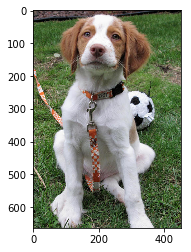

-----------------------------
hello, dog!
your predicted breed is Chesapeake_bay_retriever .


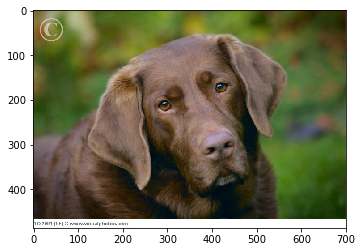

-----------------------------
hello, dog!
your predicted breed is Labrador_retriever .


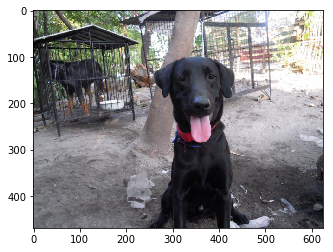

-----------------------------
sorry, there is neither human nor dog has been detected in the picture.


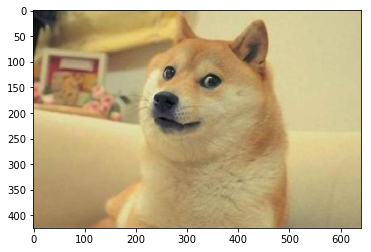

-----------------------------
hello, dog!
your predicted breed is Silky_terrier .


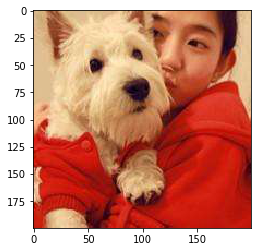

-----------------------------
hello, human!
you look like a Chihuahua .


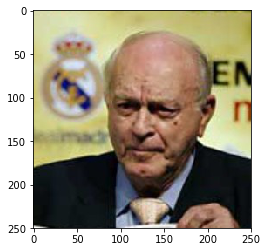

-----------------------------
hello, human!
you look like a Basenji .


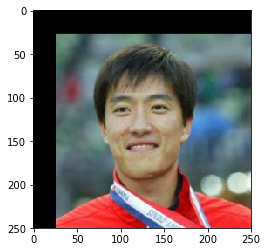

-----------------------------
hello, human!
you look like a English_toy_spaniel .


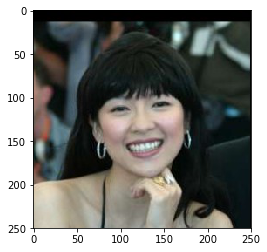

-----------------------------
hello, human!
you look like a Chihuahua .


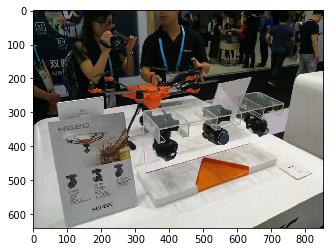

-----------------------------
hello, human!
you look like a Xoloitzcuintli .


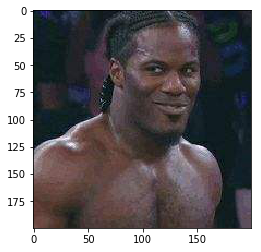

-----------------------------
sorry, there is neither human nor dog has been detected in the picture.


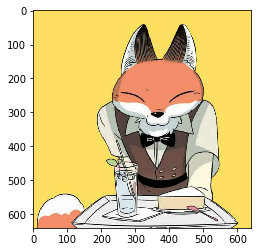

-----------------------------
sorry, there is neither human nor dog has been detected in the picture.


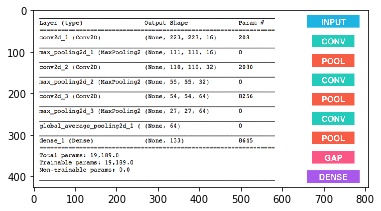

-----------------------------
sorry, there is neither human nor dog has been detected in the picture.


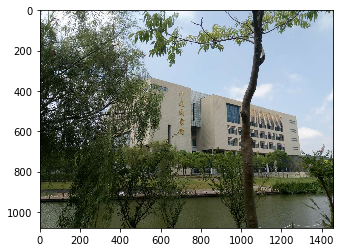

-----------------------------
sorry, there is neither human nor dog has been detected in the picture.


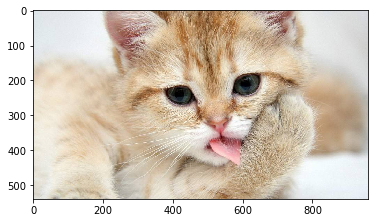

-----------------------------
sorry, there is neither human nor dog has been detected in the picture.


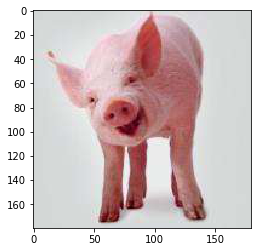

-----------------------------


In [23]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as need

plt.figure(1)
Predict_breed('images/Brittany_02625.jpg')
print('-----------------------------')
plt.figure(2)
Predict_breed('images/Labrador_retriever_06455.jpg')
print('-----------------------------')
plt.figure(3)
Predict_breed('images/Labrador_retriever_06449.jpg')
print('-----------------------------')

plt.figure(4)
Predict_breed('images/doge.jpg')
print('-----------------------------')

plt.figure(5)
Predict_breed('images/ren_dog.jpg')
print('-----------------------------')

plt.figure(6)
Predict_breed('images/Alfredo_di_Stefano_0001.jpg')
print('-----------------------------')
plt.figure(7)
Predict_breed('images/Xiang_Liu_0001.jpg')
print('-----------------------------')
plt.figure(8)
Predict_breed('images/Zhang_Ziyi_0003.jpg')
print('-----------------------------')
plt.figure(9)
Predict_breed('images/hx4.jpg')
print('-----------------------------')
plt.figure(10)
Predict_breed('images/biaoqing.jpg')
print('-----------------------------')


plt.figure(11)
Predict_breed('images/dwz.jpg')
print('-----------------------------')
plt.figure(12)
Predict_breed('images/sample_cnn.png')
print('-----------------------------')
plt.figure(13)
Predict_breed('images/smu7.jpg')
print('-----------------------------')
plt.figure(14)
Predict_breed('images/cat.jpg')
print('-----------------------------')
plt.figure(15)
Predict_breed('images/pig.jpg')
print('-----------------------------')




测试了一些图片，不同的狗狗图片5张，4个能正确预测出其种类，一个认为不包含狗的图片；不同的人像图片5张，都能检测出人脸来，并给出预测；
既不包含人像，也不含有狗狗的图片5张，也能正确判断不包含所需信息。

但是，所选图片比较理想，一般只含有一个人像或一只狗，若图片中同时包含多个目标，则此检测算法就不适用了，
所以还需改进，可以对多目标的图片进行分割，然后再对分割后只含有一个目标的图片进行种类预测。

另外，采用的人脸检测算法较为传统，会将一些狗狗的图片误认为是人脸，对于dog_files_short中100张狗狗的图片有12%的误报率，
所以还需要设计正确率更高的人脸检测算法。

狗狗的种类预测分类，采用了基于Resnet50的迁移学习方法，借用resnet50的特征向量，然后采用了较为简单的全连接层进行训练，
虽然在测试集上得到了79%的正确率，但仍有继续提升的空间，对bottleneck层之后的模型结构设计可进行优化，提高泛化能力。
